In [1]:
# Required libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import numpy as np
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.impute import SimpleImputer

In [2]:
# Load the dataset from the uploaded location
file_path ='/content/station_data_dataverse.csv'
data = pd.read_csv(file_path)


In [3]:
# Display the first few rows of the dataset and check for missing values and data types
print("Shape of the dataset:")
print(data.shape)

data_head = data.head()
print("First 5 rows of the dataset:")
print(data_head)

missing_values = data.isnull().sum()
print("Number of Missing values in the dataset, column wise:")
print(missing_values)

data_types = data.dtypes
print("Data types of each column:")
print(data_types)

Shape of the dataset:
(3395, 24)
First 5 rows of the dataset:
   sessionId  kwhTotal  dollars              created                ended  \
0    1366563      7.78     0.00  0014-11-18 15:40:26  0014-11-18 17:11:04   
1    3075723      9.74     0.00  0014-11-19 17:40:26  0014-11-19 19:51:04   
2    4228788      6.76     0.58  0014-11-21 12:05:46  0014-11-21 16:46:04   
3    3173284      6.17     0.00  0014-12-03 19:16:12  0014-12-03 21:02:18   
4    3266500      0.93     0.00  0014-12-11 20:56:11  0014-12-11 21:14:06   

   startTime  endTime  chargeTimeHrs weekday platform  ...  managerVehicle  \
0         15       17       1.510556     Tue  android  ...               0   
1         17       19       2.177222     Wed  android  ...               0   
2         12       16       4.671667     Fri  android  ...               0   
3         19       21       1.768333     Wed  android  ...               0   
4         20       21       0.298611     Thu  android  ...               0   

   fac

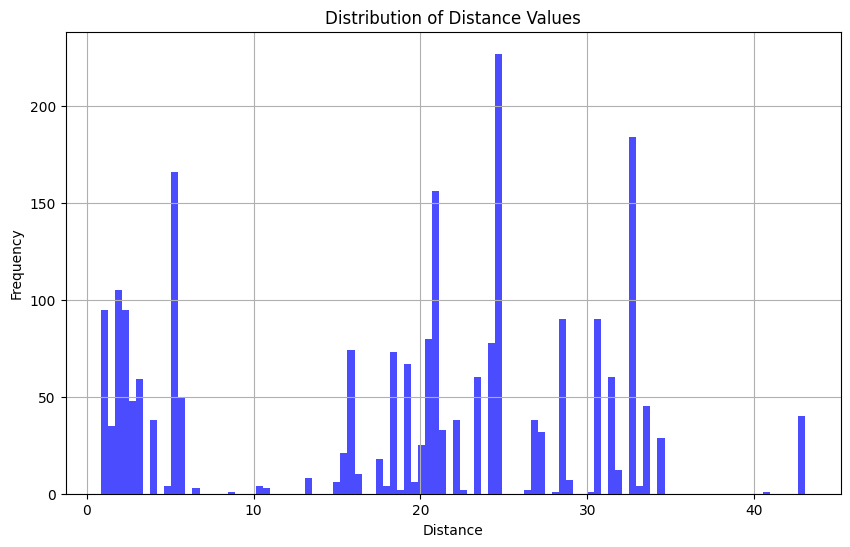

In [4]:
# 'distance' column has a lot of missing values.
# Plot the distribution of the 'distance' column
plt.figure(figsize=(10, 6))
plt.hist(data['distance'].dropna(), bins=100, color='blue', alpha=0.7)
plt.title('Distribution of Distance Values')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [5]:
# Remove rows where 'distance' is missing
cleaned_data = data.dropna(subset=['distance'])

# Print the shape of the data before and after removal of missing values to see how many rows were dropped
print("Original Data Shape:", data.shape)
print("Cleaned Data Shape:", cleaned_data.shape)

Original Data Shape: (3395, 24)
Cleaned Data Shape: (2330, 24)


In [6]:
print(cleaned_data.head())


     sessionId  kwhTotal  dollars              created                ended  \
343    7093670      5.61      0.0  0014-11-18 15:01:17  0014-11-18 18:26:04   
344    3730551      9.03      0.0  0014-11-19 19:01:41  0014-11-19 22:10:06   
345    7080329      6.95      0.0  0014-11-20 19:20:45  0014-11-20 21:48:04   
346    3829635      7.38      0.0  0014-11-21 19:02:04  0014-11-21 21:31:03   
347    6139758      6.69      0.0  0014-11-24 17:16:19  0014-11-24 19:31:04   

     startTime  endTime  chargeTimeHrs weekday platform  ...  managerVehicle  \
343         15       18       3.413056     Tue      ios  ...               0   
344         19       22       3.140278     Wed      ios  ...               0   
345         19       21       2.455278     Thu      ios  ...               0   
346         19       21       2.483056     Fri      ios  ...               0   
347         17       19       2.245833     Mon      ios  ...               0   

     facilityType  Mon  Tues  Wed  Thurs  Fr

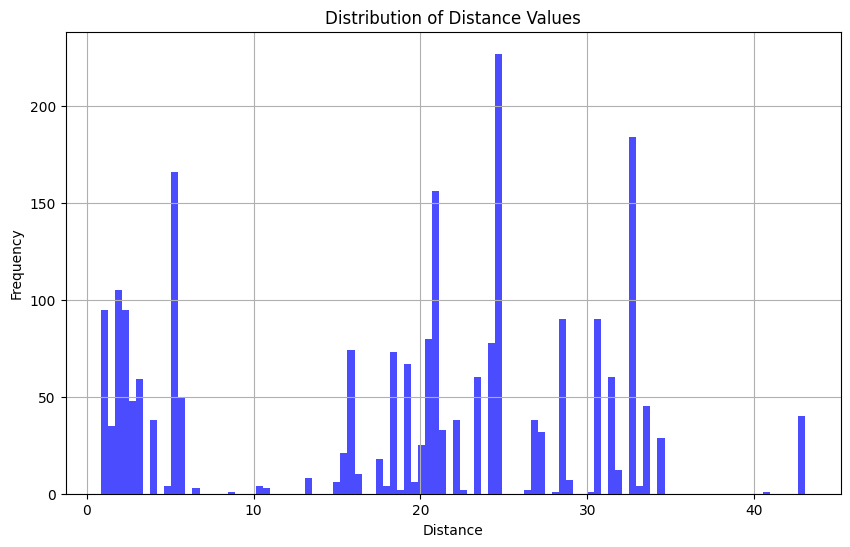

In [7]:
# Plot the distribution of the 'distance' column, after removing the missing values
plt.figure(figsize=(10, 6))
plt.hist(cleaned_data['distance'].dropna(), bins=100, color='blue', alpha=0.7)
plt.title('Distribution of Distance Values')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

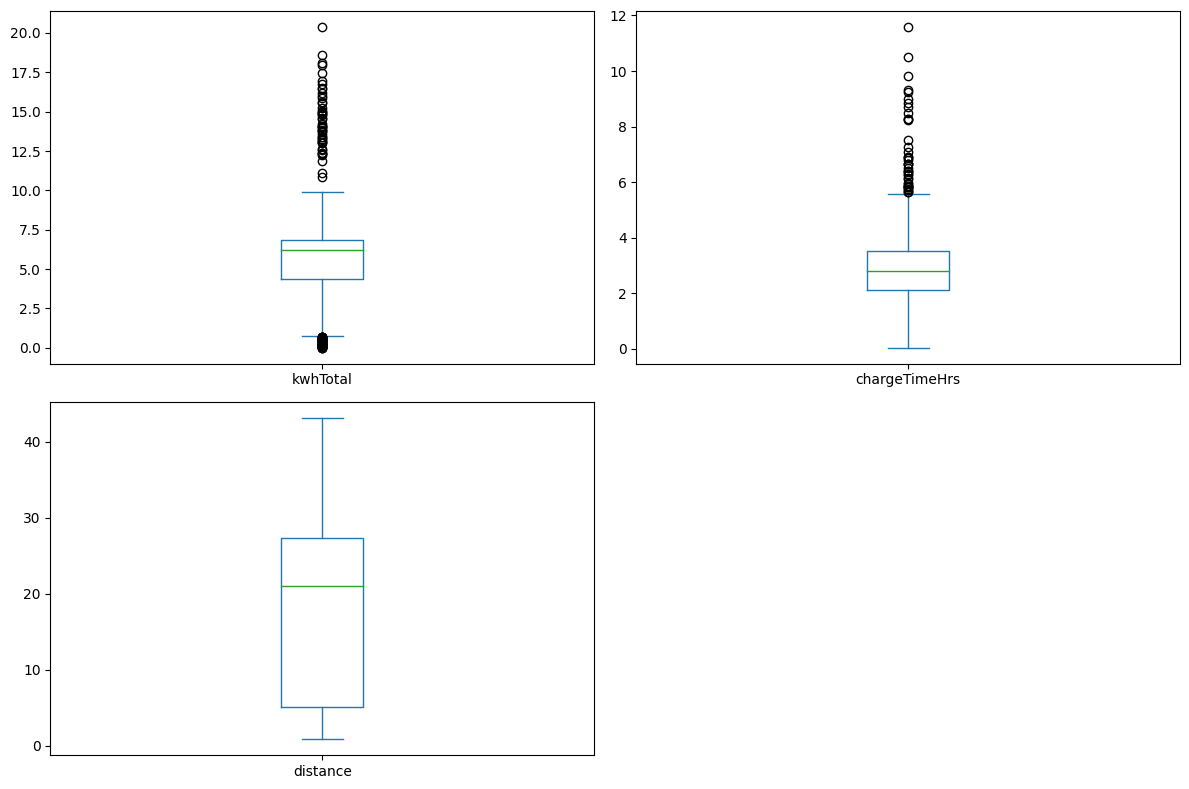

In [8]:
# Boxplots for numerical columns to identify outliers
selected_columns = ['kwhTotal', 'chargeTimeHrs', 'distance']
cleaned_data[selected_columns].plot(kind='box', figsize=(12, 8), subplots=True, layout=(2, 2), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

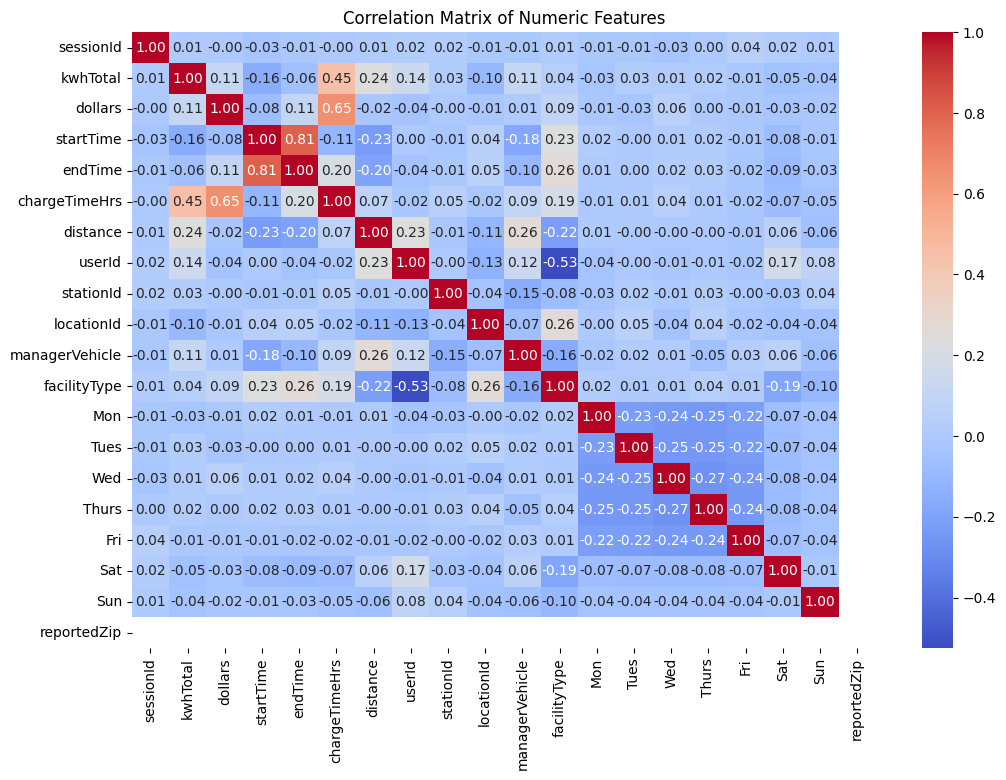

In [9]:
# Correlation matrix heatmap
numeric_columns = cleaned_data.select_dtypes(include=[np.number])
correlation_matrix = numeric_columns.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

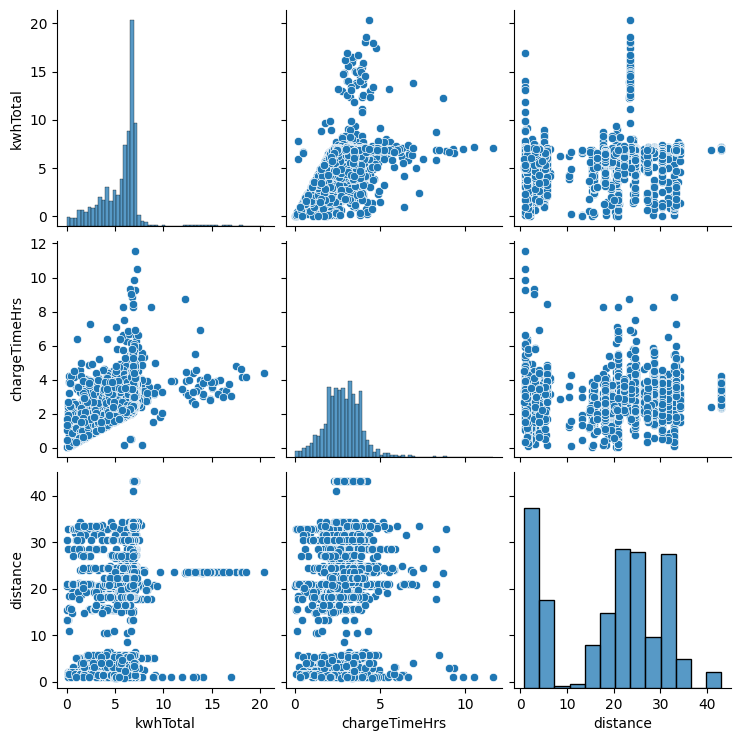

In [10]:
# Pair plot on columns to visualize relationships between features
selected_columns = ['kwhTotal', 'chargeTimeHrs', 'distance']
sns.pairplot(cleaned_data[selected_columns])
plt.show()

In [11]:
print(cleaned_data.head())

     sessionId  kwhTotal  dollars              created                ended  \
343    7093670      5.61      0.0  0014-11-18 15:01:17  0014-11-18 18:26:04   
344    3730551      9.03      0.0  0014-11-19 19:01:41  0014-11-19 22:10:06   
345    7080329      6.95      0.0  0014-11-20 19:20:45  0014-11-20 21:48:04   
346    3829635      7.38      0.0  0014-11-21 19:02:04  0014-11-21 21:31:03   
347    6139758      6.69      0.0  0014-11-24 17:16:19  0014-11-24 19:31:04   

     startTime  endTime  chargeTimeHrs weekday platform  ...  managerVehicle  \
343         15       18       3.413056     Tue      ios  ...               0   
344         19       22       3.140278     Wed      ios  ...               0   
345         19       21       2.455278     Thu      ios  ...               0   
346         19       21       2.483056     Fri      ios  ...               0   
347         17       19       2.245833     Mon      ios  ...               0   

     facilityType  Mon  Tues  Wed  Thurs  Fr

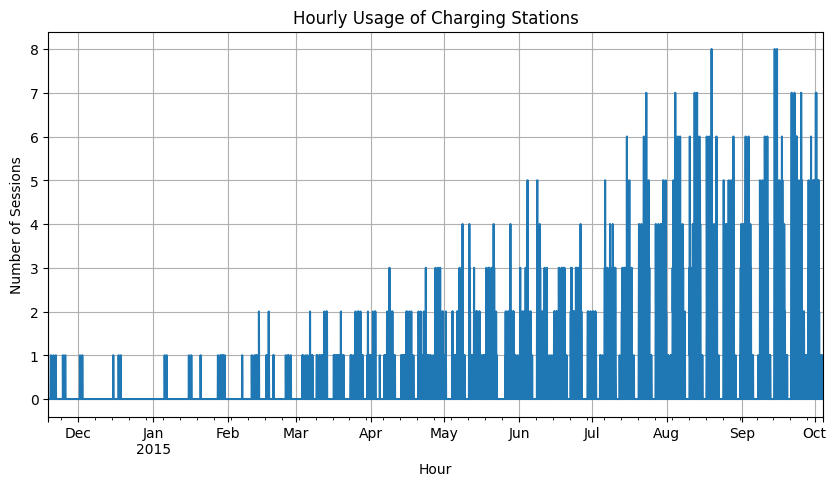

In [12]:
# Function to adjust the year in the datetime string
def adjust_year(date_str):
    if pd.isna(date_str):
        return date_str  # Return as is if NaN
    parts = date_str.split('-')
    if len(parts[0]) == 4 and parts[0].startswith('00'):
        # Assuming all years are 2000s, adjust accordingly if it varies
        parts[0] = '20' + parts[0][2:]  # Change '0014' to '2014'
    return '-'.join(parts)

# Apply the function to adjust the year format
cleaned_data.loc[:,'created'] = cleaned_data['created'].apply(adjust_year)

# Now convert to datetime
cleaned_data.loc[:,'created'] = pd.to_datetime(cleaned_data['created'], format="%Y-%m-%d %H:%M:%S", errors='coerce')

# Check for NaT values after conversion
if cleaned_data['created'].isna().any():
    print("Conversion resulted in NaT values, check the original data for inconsistencies.")

# Group by 'created' datetime and resample to hourly data
hourly_usage = cleaned_data.groupby(pd.Grouper(key='created', freq='H')).count()['sessionId']

# Plot
hourly_usage.plot(kind='line', figsize=(10, 5), title='Hourly Usage of Charging Stations')
plt.xlabel('Hour')
plt.ylabel('Number of Sessions')
plt.grid(True)
plt.show()

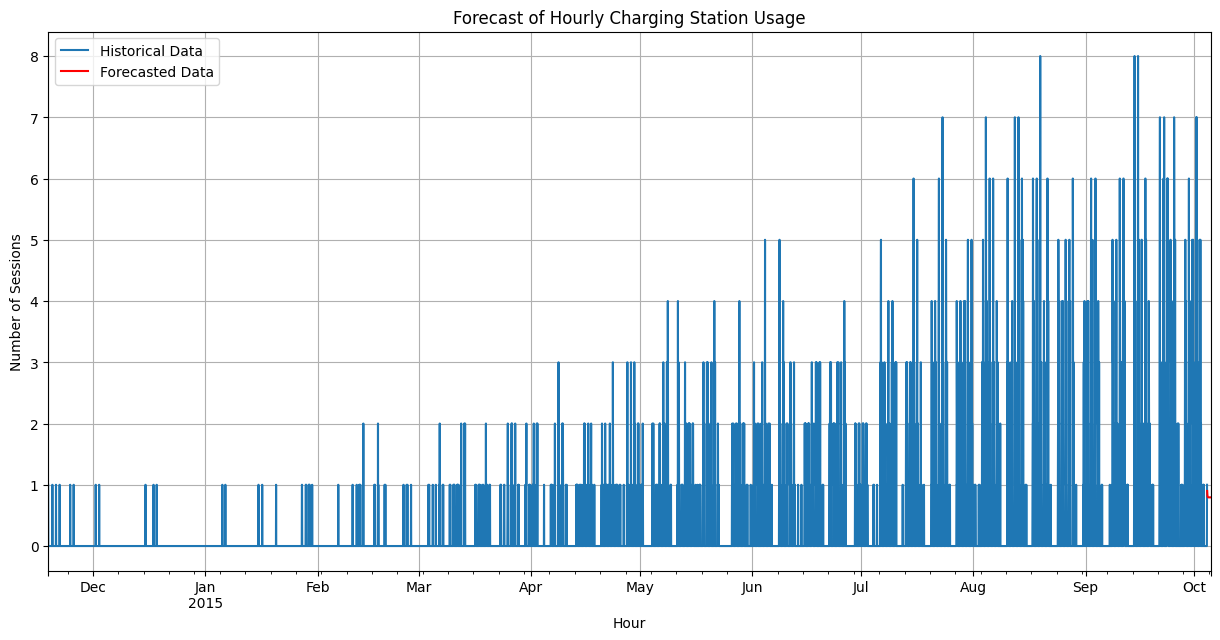

In [13]:
# Handling ARIMA model fitting on hourly usage data

# Fit an ARIMA model for forecasting future trends
model = ARIMA(hourly_usage.astype(float), order=(1, 1, 1))
model_fit = model.fit()

# Forecast the next 24 hours
forecast = model_fit.forecast(steps=24)

# Plotting the forecast alongside historical data
plt.figure(figsize=(15, 7))
hourly_usage.plot(label='Historical Data')
forecast.plot(label='Forecasted Data', color='red')
plt.title('Forecast of Hourly Charging Station Usage')
plt.xlabel('Hour')
plt.ylabel('Number of Sessions')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# kwhTotal', 'chargeTimeHrs', and 'distance' are relevant features for clustering
features = ['kwhTotal', 'chargeTimeHrs', 'distance']
data_for_clustering = cleaned_data[features]

In [15]:
# Normalize the data to ensure fair comparison and effective distance computation
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

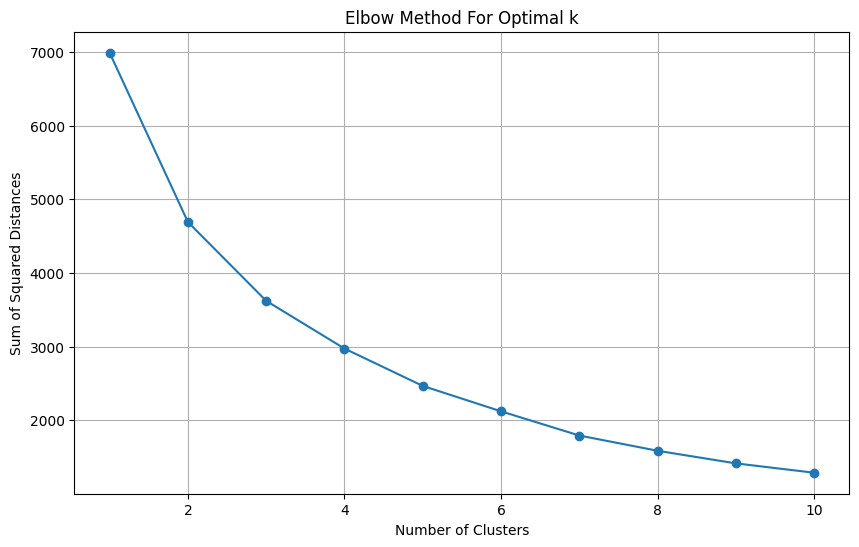

In [16]:
# Calculate the sum of squared distances of samples to their closest cluster center
sse = []
# Test for 1 to 10 clusters
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42,n_init=10)
    kmeans.fit(scaled_data)
    # Inertia: Sum of squared distances of samples to their closest cluster center
    sse.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.grid(True)

In [17]:
# Applying K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42,n_init=10)
clusters = kmeans.fit_predict(scaled_data)

In [18]:
# Adding cluster information back to the original data
cleaned_data['Cluster'] = clusters

<ipython-input-18-56ab646b8d37>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['Cluster'] = clusters


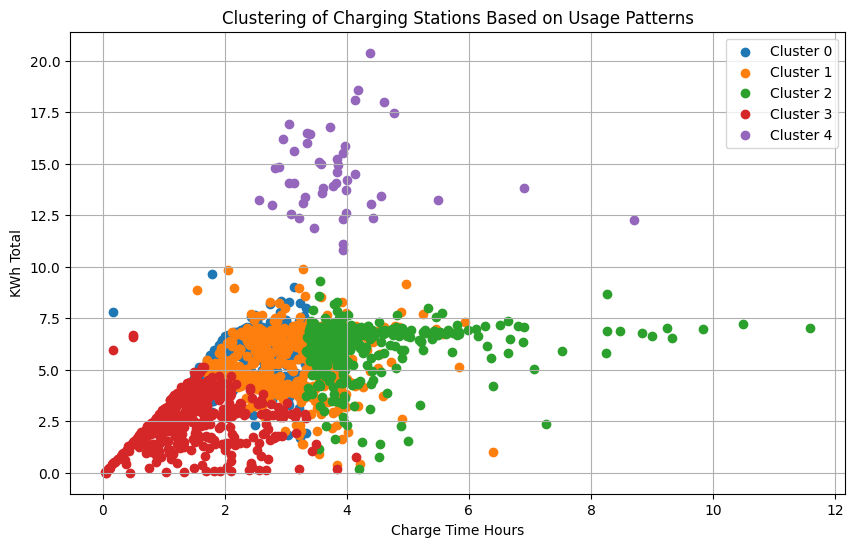

In [19]:
# Visualizing the clusters
plt.figure(figsize=(10, 6))
for c in range(kmeans.n_clusters):
    cluster_data = cleaned_data[cleaned_data.loc[:,'Cluster'] == c]
    plt.scatter(cluster_data['chargeTimeHrs'], cluster_data['kwhTotal'], label=f'Cluster {c}')  # Adjust axes as needed

plt.title('Clustering of Charging Stations Based on Usage Patterns')
plt.xlabel('Charge Time Hours')
plt.ylabel('KWh Total')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Analyze cluster centers to understand typical usage patterns
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features)
print(centers)

    kwhTotal  chargeTimeHrs   distance
0   6.303710       2.586149  26.317973
1   5.575750       3.079956   3.663818
2   6.262220       4.179071  24.967432
3   2.550689       1.471854  13.648124
4  14.534894       3.880591  20.649003


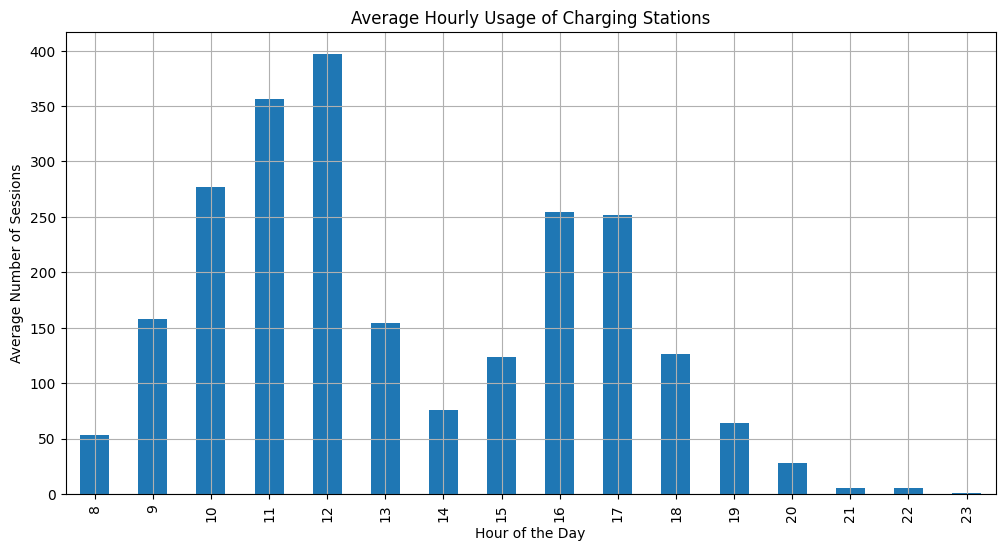

In [21]:
# Grouping data by hour of the day and calculating the mean number of sessions per hour
hourly_usage = cleaned_data.groupby('startTime').size()

# Plotting the hourly usage
plt.figure(figsize=(12, 6))
hourly_usage.plot(kind='bar')
plt.title('Average Hourly Usage of Charging Stations')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Sessions')
plt.grid(True)
plt.show()

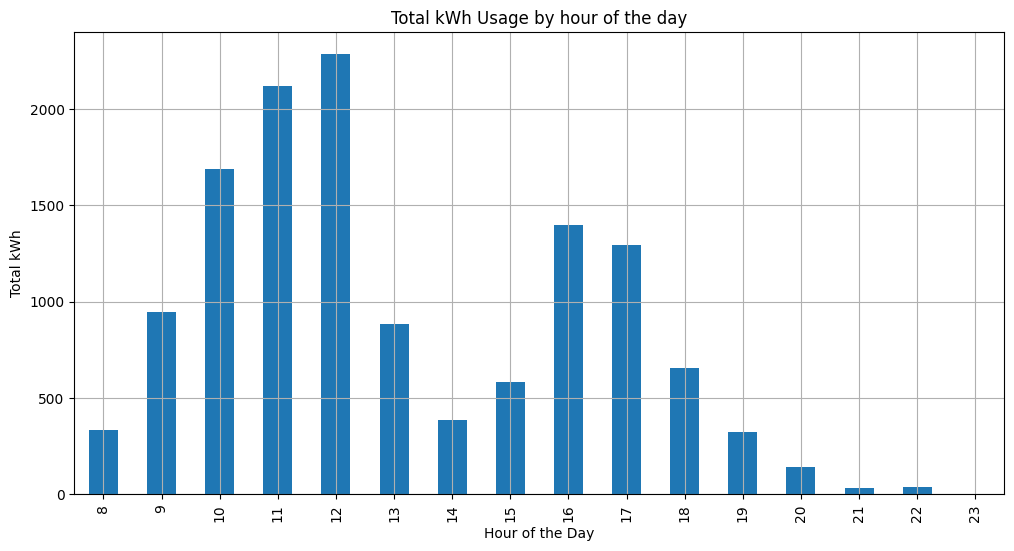

In [22]:
# Grouping data by hour of the day and calculating the sum of the 'kwhTotal' for each hour
hourly_usage = cleaned_data.groupby('startTime')['kwhTotal'].sum()

# Plotting the hourly usage
plt.figure(figsize=(12, 6))
hourly_usage.plot(kind='bar')
plt.title('Total kWh Usage by hour of the day')
plt.xlabel('Hour of the Day')
plt.ylabel('Total kWh')
plt.grid(True)
plt.show()

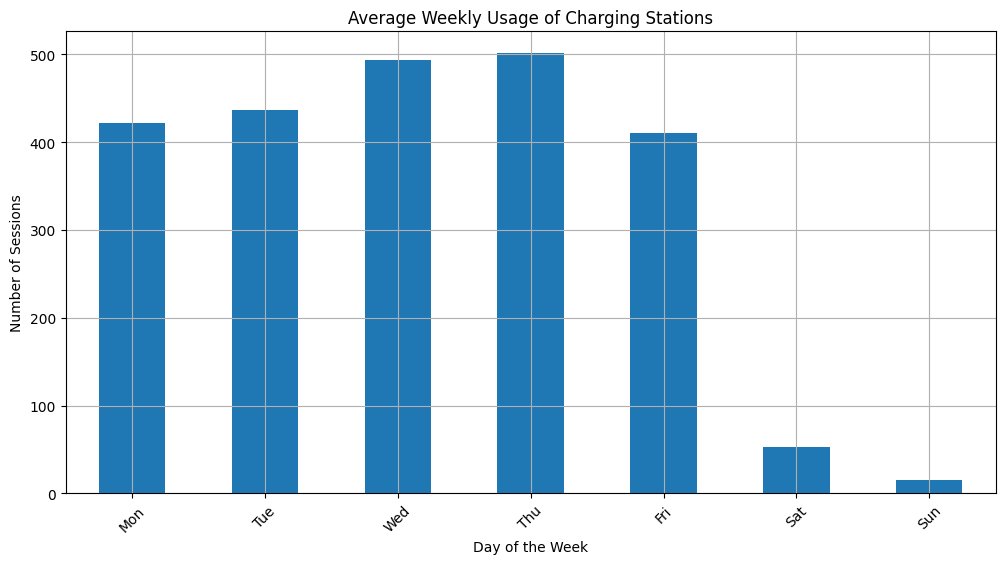

In [23]:
# Grouping data by the 'weekday' column and calculating the number of sessions per day
weekly_usage = cleaned_data.groupby('weekday').size()

# Since the 'weekday' might not be in order, you can manually order them if needed
days_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekly_usage = weekly_usage.reindex(days_order)

# Plotting the weekly usage
plt.figure(figsize=(12, 6))
weekly_usage.plot(kind='bar')
plt.title('Average Weekly Usage of Charging Stations')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Sessions')
# Rotates the labels for better readability
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


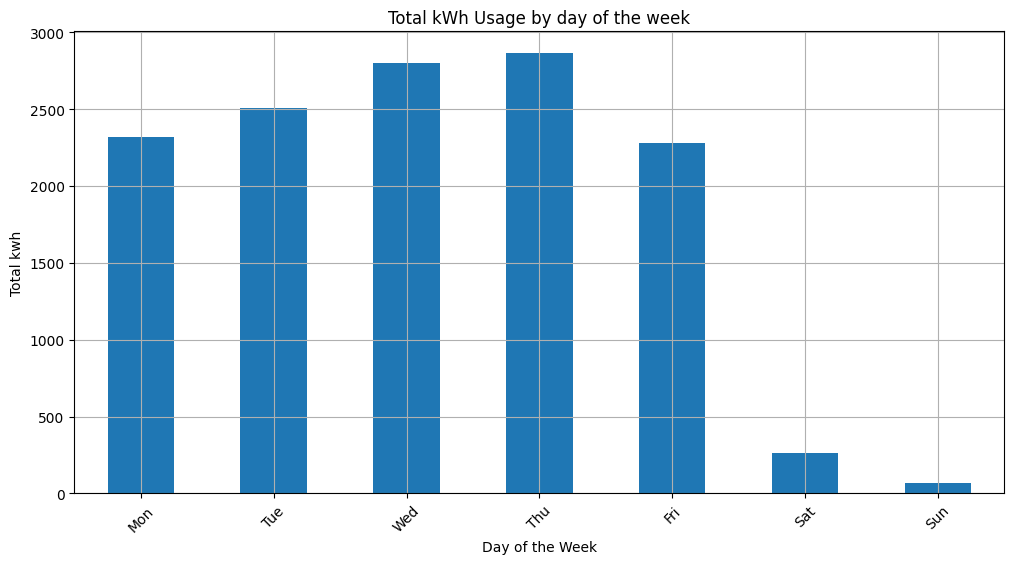

In [24]:
# Grouping data by the 'weekday' column and calculating the sum of kwhTotal per day
weekly_usage = cleaned_data.groupby('weekday')['kwhTotal'].sum()

# Since the 'weekday' might not be in order, you can manually order them if needed
days_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekly_usage = weekly_usage.reindex(days_order)

# Plotting the weekly usage
plt.figure(figsize=(12, 6))
weekly_usage.plot(kind='bar')
plt.title('Total kWh Usage by day of the week')
plt.xlabel('Day of the Week')
plt.ylabel('Total kwh')
# Rotates the labels for better readability
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [25]:
print(cleaned_data.dtypes)

sessionId           int64
kwhTotal          float64
dollars           float64
created            object
ended              object
startTime           int64
endTime             int64
chargeTimeHrs     float64
weekday            object
platform           object
distance          float64
userId              int64
stationId           int64
locationId          int64
managerVehicle      int64
facilityType        int64
Mon                 int64
Tues                int64
Wed                 int64
Thurs               int64
Fri                 int64
Sat                 int64
Sun                 int64
reportedZip         int64
Cluster             int32
dtype: object


In [26]:
# Correct the year in the datetime columns
def correct_year(date_str):
    # Convert Timestamp to string if not already a string
    date_str = str(date_str)
    if date_str.startswith('00'):
        return '20' + date_str[2:]
    return date_str

# Convert the dates from strings to correct strings, then to datetime
cleaned_data['created'] = cleaned_data['created'].astype(str).apply(correct_year)
cleaned_data['ended'] = cleaned_data['ended'].astype(str).apply(correct_year)

cleaned_data['created'] = pd.to_datetime(cleaned_data['created'], errors='coerce')
cleaned_data['ended'] = pd.to_datetime(cleaned_data['ended'], errors='coerce')

# Initialize DataFrame for availability
availability_data = pd.DataFrame()

# Add the columns to be used
features = ['kwhTotal', 'chargeTimeHrs', 'distance', 'facilityType']

for station in cleaned_data['stationId'].unique():
    station_data = cleaned_data[cleaned_data['stationId'] == station]
    station_data['hour'] = station_data['created'].dt.floor('H')

    # Creating a DataFrame for each hour that a station operates
    hours = pd.date_range(start=station_data['hour'].min(), end=station_data['hour'].max(), freq='H')
    hourly_data = pd.DataFrame(hours, columns=['hour'])
    hourly_data['stationId'] = station  # Track the station ID if needed
    hourly_data['available'] = 1  # Assume initially all hours are available

    # Mark hours as unavailable when they fall within any session times
    for _, row in station_data.iterrows():
        hourly_data.loc[(hourly_data['hour'] >= row['created'].floor('H')) & (hourly_data['hour'] <= row['ended'].floor('H')), 'available'] = 0

    # Adding features
    for feature in features:
        # Using mean here as an example aggregation method, adjust as needed
        hourly_data[feature] = np.mean(station_data[feature])  # Fill with the average or another appropriate aggregation

    availability_data = pd.concat([availability_data, hourly_data.drop_duplicates()], ignore_index=True)


<ipython-input-26-29e6bc4a3160>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['created'] = cleaned_data['created'].astype(str).apply(correct_year)
<ipython-input-26-29e6bc4a3160>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['ended'] = cleaned_data['ended'].astype(str).apply(correct_year)
<ipython-input-26-29e6bc4a3160>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [27]:
# Selecting features and target
features = ['kwhTotal', 'chargeTimeHrs', 'distance', 'facilityType']
X = availability_data[features]
y = availability_data['available']

In [28]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape input to be 3D [samples, timesteps, features] for CNN
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [29]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
model = Sequential([
    # Input shape is (4, 1) where 4 is the number of timesteps and 1 is the number of features per timestep
    Conv1D(filters=32, kernel_size=1, activation='relu', padding='same', input_shape=(4, 1)),
    # Minimal pooling to avoid dimensionality reduction
    Conv1D(filters=64, kernel_size=1, activation='relu', padding='same'),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
# Fit the model on SMOTE data
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
_, accuracy = model.evaluate(X_test, y_test)
print(f"Model accuracy: {accuracy:.2f}")

Epoch 1/5
7145/7145 [==============================] - 24s 3ms/step - loss: 0.1353 - accuracy: 0.9698 - val_loss: 0.1266 - val_accuracy: 0.9702
Epoch 2/5
7145/7145 [==============================] - 24s 3ms/step - loss: 0.1310 - accuracy: 0.9698 - val_loss: 0.1283 - val_accuracy: 0.9702
Epoch 3/5
7145/7145 [==============================] - 24s 3ms/step - loss: 0.1296 - accuracy: 0.9698 - val_loss: 0.1262 - val_accuracy: 0.9702
Epoch 4/5
7145/7145 [==============================] - 21s 3ms/step - loss: 0.1288 - accuracy: 0.9698 - val_loss: 0.1262 - val_accuracy: 0.9702
Epoch 5/5
1787/1787 [==============================] - 4s 2ms/step - loss: 0.1258 - accuracy: 0.9702
Model accuracy: 0.97


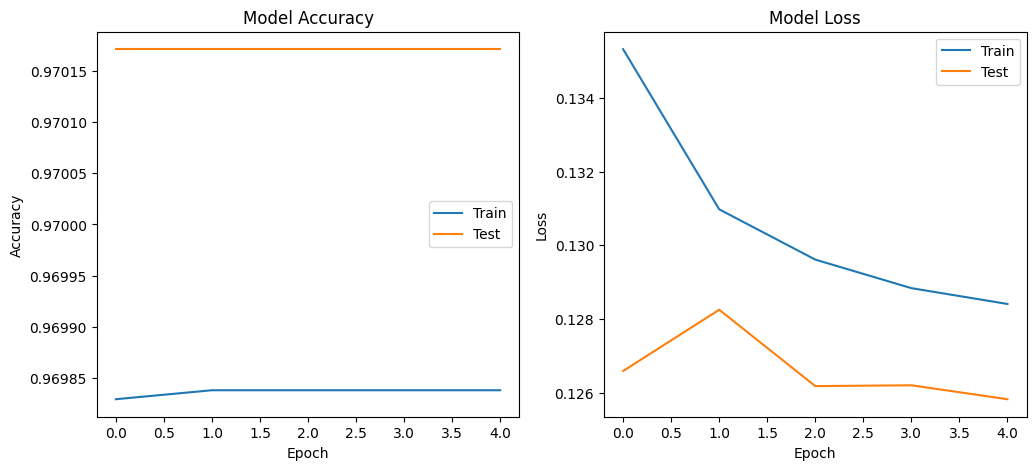

In [32]:
# Plot training history for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

